## Table of Contents
- [Problem Statement and Motivation](#statement)
- [About Data](#data)
- [Data Gathering](#gather) 
- [Data Exploration](#explore)
- [Exploratory Data Analysis (EDA)](#eda)
- [Data Quality Issues](#clean)
- [Modeling](#model)
- [Discussion of Results](#result)
- [Conclusion](#conclude)

<a id='statement'></a>
## Problem Statement and Motivation

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Using the client’s billing history, the aim of the challenge is to detect and recognize clients involved in fraudulent activities.

The solution will enhance the company’s revenues and reduce the losses caused by such fraudulent activities.

<a id='data'></a>
## About Datasets

The data provided by STEG is composed of two files. The first one is comprised of client data and the second one contains billing history from 2005 to 2019.

There are 2 .zip files, train.zip, and test.zip and a SampleSubmission.csv. In each .zip file you will find a client and invoice file.

__Variable definitions__

1. Client:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0
- Invoice data

2. Invoice data:

- Client_id: Unique id for the client
- Invoice_date: Date of the invoice
- Tarif_type: Type of tax
- Counter_number:
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Old_index: Old index
- New_index: New index
- Months_number: Month number
- Counter_type: Type of counter


## DESCRIPTION
### FILES

_train.zip_: Train contains the target. This is the dataset that you will use to train your model.

_test.zip_: Test resembles Train.csv but without the target-related columns. This is the dataset on which you will apply to your model.

 
_SampleSubmission.csv_: This shows the submission format for this competition, with the ‘ID’ column mirroring that of Test.csv and the ‘target’ column containing your predictions. The order of the rows does not matter, but the names of the ID must be correct.

In [1]:
# Load the necessary libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

<a id='gather'></a>
## Data Gathering

In [2]:
# Unzip files
zipfiles = ['test.zip', 'train.zip']
for file in zipfiles:
    with zipfile.ZipFile(file, 'r') as f:
        f.extractall()

In [3]:
# Check available files in current directory
os.listdir()

['.ipynb_checkpoints',
 'client_test.csv',
 'client_train.csv',
 'invoice_test.csv',
 'invoice_train.csv',
 'README.md',
 'SampleSubmission.csv',
 'submission.csv',
 'test.zip',
 'train.zip',
 'transaction_challenge.ipynb']

In [4]:
# Read client data
client_test = pd.read_csv('client_test.csv')
client_train = pd.read_csv('client_train.csv')

In [5]:
# Read invoice data
invoice_test = pd.read_csv('invoice_test.csv')
invoice_train = pd.read_csv('invoice_train.csv', dtype= {'counter_statue': np.str_})

In [6]:
# Read sample submission data
sample_submission = pd.read_csv('SampleSubmission.csv',)

<a id='explore'></a>
## Data Exploration

In [7]:
# Print first 5 rows
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [8]:
# Print client train df information
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [9]:
# Investigate uniqueness of target column
client_train.target.unique()

array([0., 1.])

In [10]:
client_train.client_id.unique()

array(['train_Client_0', 'train_Client_1', 'train_Client_10', ...,
       'train_Client_99997', 'train_Client_99998', 'train_Client_99999'],
      dtype=object)

In [11]:
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [12]:
# Check for unique value differences in disrict
np.setdiff1d(client_test.disrict.unique(), client_train.disrict.unique())

array([], dtype=int64)

In [13]:
# Check for unique value differences in client_catg
np.setdiff1d(client_train.client_catg.unique(), client_test.client_catg.unique())

array([], dtype=int64)

In [14]:
# Check for unique value differences in region
np.setdiff1d(client_test.region.unique(), client_train.region.unique())

array([], dtype=int64)

The values in `disrict`, `client_catg`, and `region` are the same in `client_train` and `client_test` respectively. `client_id` is the only column in both dataframes that contain different values.

In [15]:
client_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   disrict        58069 non-null  int64 
 1   client_id      58069 non-null  object
 2   client_catg    58069 non-null  int64 
 3   region         58069 non-null  int64 
 4   creation_date  58069 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.2+ MB


In [16]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [17]:
# Print information of invoice_train df
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [18]:
# Check the shape of invoice_train dataframe
invoice_train.shape

(4476749, 16)

In [19]:
# Check unique values
invoice_train.counter_statue.unique()

array(['0', '1', '5', '4', '3', '2', '769', 'A', '618', '269375', '46',
       '420'], dtype=object)

In [20]:
# Investigate activities with counter_status = A
invoice_train[(invoice_train.counter_statue=='A')]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
1923231,train_Client_30467,2011-11-07,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923237,train_Client_30467,2007-04-17,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923240,train_Client_30467,2005-11-08,15,9505424,A,202,6,1,0,0,0,0,3922,3922,4,ELEC
1923241,train_Client_30467,2006-11-12,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923242,train_Client_30467,2012-10-07,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923247,train_Client_30467,2012-03-13,15,9505424,A,202,6,1,0,0,0,0,3972,3972,8,ELEC
1923251,train_Client_30467,2006-04-18,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923267,train_Client_30467,2006-08-14,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923270,train_Client_30467,2012-11-13,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923271,train_Client_30467,2007-11-12,15,9505424,A,202,6,1,0,0,0,0,3972,3972,8,ELEC


In [21]:
# Investigate activities of train_Client_30467
invoice_train[(invoice_train.client_id == 'train_Client_30467')]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
1923228,train_Client_30467,2015-10-11,15,9505424,0,202,6,1,0,0,0,0,3972,3972,2,ELEC
1923229,train_Client_30467,2015-10-11,10,3968865,0,202,8,1,104,0,0,0,56450,56554,2,ELEC
1923230,train_Client_30467,2005-09-12,40,12655,0,5,6,1,146,0,0,0,7724,7870,4,GAZ
1923231,train_Client_30467,2011-11-07,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC
1923232,train_Client_30467,2011-11-07,10,3968865,0,202,6,1,200,331,0,0,48564,49095,4,ELEC
1923233,train_Client_30467,2018-07-03,40,12655,0,5,8,1,0,0,0,0,13679,13679,16,GAZ
1923234,train_Client_30467,2018-07-03,15,9505424,0,202,6,1,0,0,0,0,3922,3922,16,ELEC
1923235,train_Client_30467,2007-11-12,10,3968865,0,202,6,1,400,1177,0,0,41696,43273,8,ELEC
1923236,train_Client_30467,2007-04-17,40,12655,0,5,9,1,733,0,0,0,8851,9584,4,GAZ
1923237,train_Client_30467,2007-04-17,15,9505424,A,202,6,1,0,0,0,0,3972,3972,4,ELEC


It seems counter_statue for train_Client_30467 should be 0 instead of A. This error is definitely a typo.

In [22]:
# Print first 5 rows of invoice_test df
invoice_test.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC


In [23]:
invoice_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1939730 entries, 0 to 1939729
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        int64 
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(13), object(3)
memory usage: 236.8+ MB


In [24]:
# Check the unique values of counter_status in invoice_test
invoice_test.counter_statue.unique()

array([0, 1, 5, 4, 3, 2], dtype=int64)

In [25]:
# Check the number of unique values for all columns in invoice_test
invoice_train.nunique()

client_id               135493
invoice_date              8275
tarif_type                  17
counter_number          201893
counter_statue              12
counter_code                42
reading_remarque             8
counter_coefficient         16
consommation_level_1      8295
consommation_level_2     12576
consommation_level_3      2253
consommation_level_4     12075
old_index               155648
new_index               157980
months_number             1370
counter_type                 2
dtype: int64

In [26]:
# Check the unique values of counter_type in invoice_test
invoice_train.counter_type.unique()

array(['ELEC', 'GAZ'], dtype=object)

In [27]:
sample_submission.head()

,client_id,target
0,test_Client_0,0.957281
1,test_Client_1,0.996425
2,test_Client_10,0.612359
3,test_Client_100,0.776933
4,test_Client_1000,0.571046


<a id='eda'></a>
## Exploratory Data Analysis (EDA)

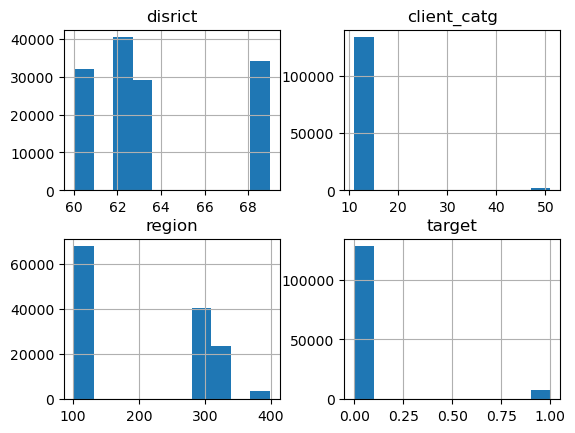

In [28]:
client_train.hist();

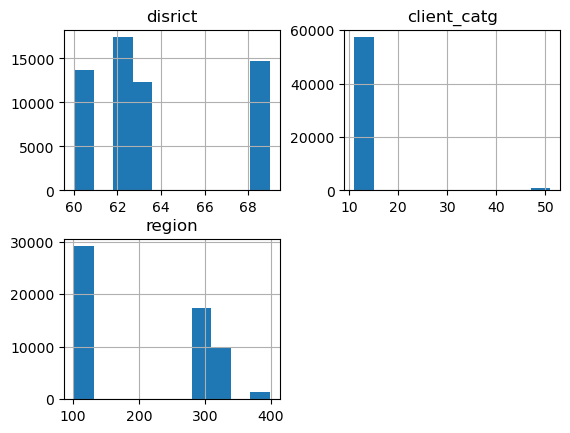

In [29]:
client_test.hist();

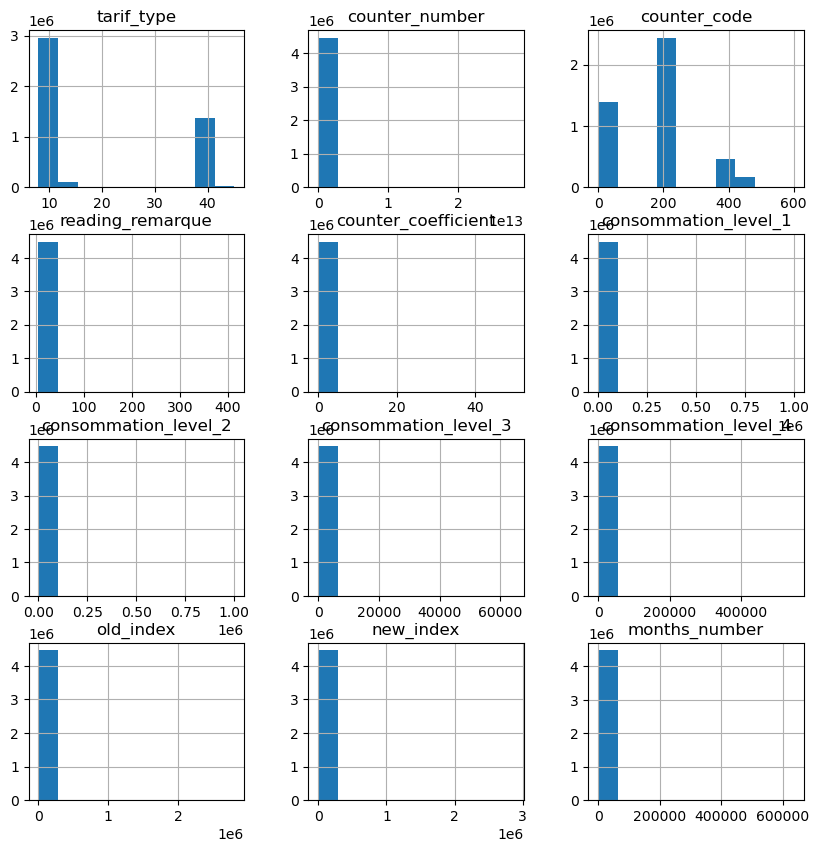

In [30]:
invoice_train.hist(figsize=(10,10));

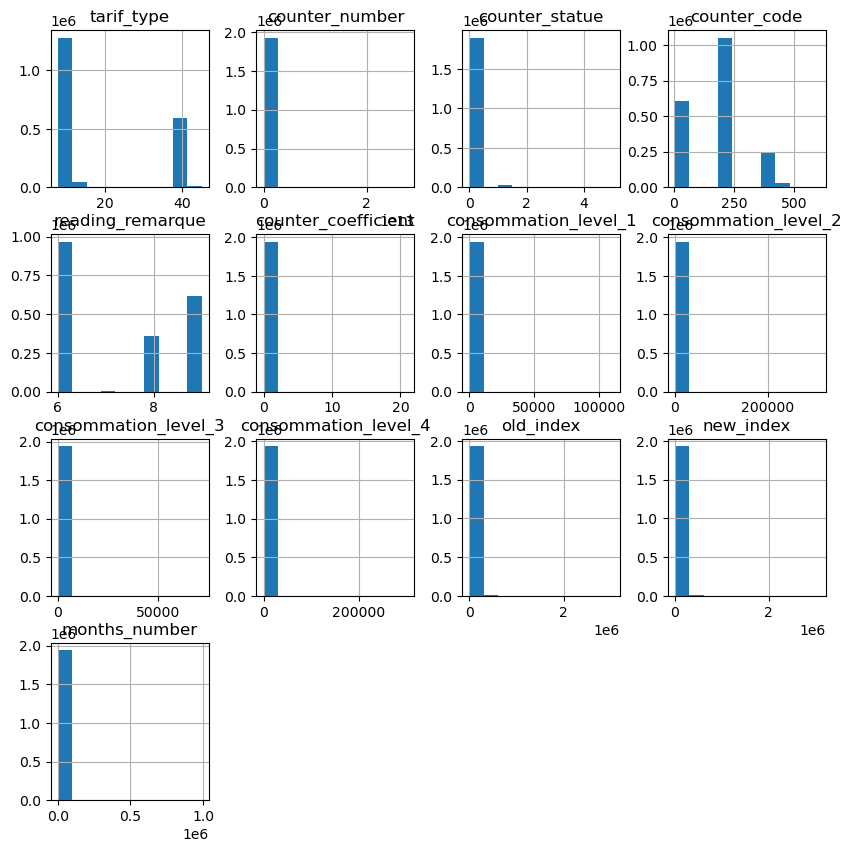

In [31]:
invoice_test.hist(figsize=(10, 10));

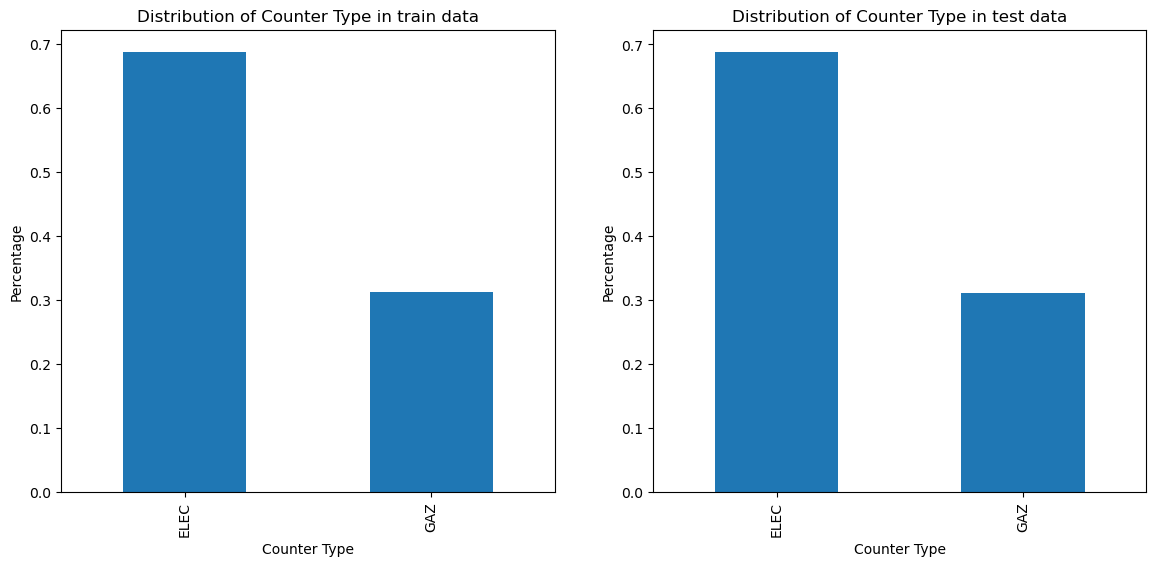

In [32]:
def bar_1():
    
    '''
    Plot 2 Bar Charts showing the distribution of Counter Type in 
    train and test data.
    
    Input: 
        None
    Output: two bar charts for train and test data
    '''
    
    plt.figure(figsize=[14,6])
    plt.subplot(121)
    invoice_train.counter_type.value_counts(normalize=True).plot(kind = 'bar');
    plt.xlabel('Counter Type')
    plt.ylabel('Percentage')
    plt.title('Distribution of Counter Type in train data')
    
    plt.subplot(122)
    invoice_test.counter_type.value_counts(normalize=True).plot(kind = 'bar');
    plt.xlabel('Counter Type')
    plt.ylabel('Percentage')
    plt.title('Distribution of Counter Type in test data')
bar_1()

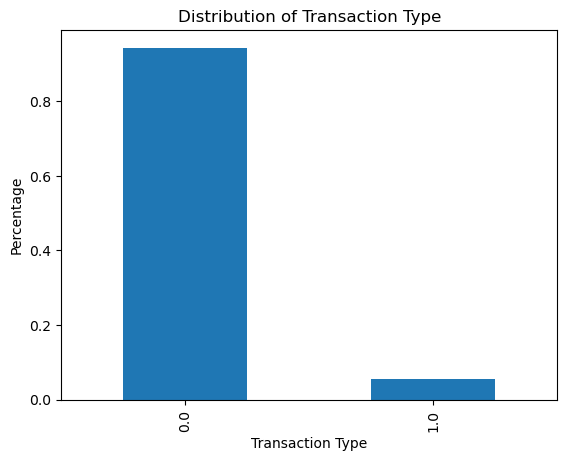

In [33]:
def bar_2():
    
    '''
    Plot a Bar Chart Showing Distribution of Transaction Type.
    
    Input: 
        None
    Output: bar plot
    '''
    
    client_train.target.value_counts(normalize=True).plot(kind = 'bar');
    plt.xlabel('Transaction Type')
    plt.ylabel('Percentage')
    plt.title('Distribution of Transaction Type')
bar_2()

Few takes from the EDA are:
1. Trends in all the given datasets are somewhat the same which strongly suggests they are from the same source.
2. Over 90% transactions are not fraud. Less than 10% deals are fraud.

<a id='clean'></a>
## Data Quality Issues:

In this project, I will build a model to classify the client dataset. To make it ready, I have to do the following: 

1. Change `disrict`, `client_catg` to `district` and `client_categories` respectively.<br>
2. `creation_date` should be converted to datetime.

In [34]:
def wrangle_client(df, col1, col2, col3):
    """
    Wrangle client dataset.
    
    Attributes: 
            df: client data,
            col1: disrict, 
            col2: client_catg, 
            col3: creation_date
    Returns: 
        new_df: a wrangled client dataftame
    """
    # Rename columns
    new_df = df.rename(columns = {
        col1: 'district',
        col2: 'client_categories'
    })
    # Convert creation_date to datetime
    new_df[col3] = pd.to_datetime(new_df[col3], 
                                  yearfirst=True, 
                                  format= "%d/%m/%Y")
    return new_df

In [35]:
# Form new client dataframes
new_client_train = wrangle_client(client_train, 'disrict', 'client_catg', 'creation_date')
new_client_test = wrangle_client(client_test, 'disrict', 'client_catg', 'creation_date')

In [36]:
# Print first 5 rows
new_client_train.head()

,district,client_id,client_categories,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0.0
1,69,train_Client_1,11,107,2002-05-29,0.0
2,62,train_Client_10,11,301,1986-03-13,0.0
3,69,train_Client_100,11,105,1996-07-11,0.0
4,62,train_Client_1000,11,303,2014-10-14,0.0


In [37]:
# Print dataframe information
new_client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   district           135493 non-null  int64         
 1   client_id          135493 non-null  object        
 2   client_categories  135493 non-null  int64         
 3   region             135493 non-null  int64         
 4   creation_date      135493 non-null  datetime64[ns]
 5   target             135493 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.2+ MB


In [38]:
# Print first 5 rows
new_client_test.head()

,district,client_id,client_categories,region,creation_date
0,62,test_Client_0,11,307,2002-05-28
1,69,test_Client_1,11,103,2009-08-06
2,62,test_Client_10,11,310,2004-04-07
3,60,test_Client_100,11,101,1992-10-08
4,62,test_Client_1000,11,301,1977-07-21


In [39]:
new_client_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   district           58069 non-null  int64         
 1   client_id          58069 non-null  object        
 2   client_categories  58069 non-null  int64         
 3   region             58069 non-null  int64         
 4   creation_date      58069 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.2+ MB


<a id='model'></a>
## Modeling

In [40]:
# Drop unwanted columns from independent variables
X_train = new_client_train.drop(['target', 'client_id', 'creation_date'], axis = 1)
X_test = new_client_test.drop(['client_id', 'creation_date'], axis = 1)

# Get target variable
y_train = new_client_train.target

In [41]:
def build_model():
    
   
    """
    Build Machine Learning Pipeline.
    
    Attributes: 
            None
    Returns: 
        pipeline
    """
    # Create a random forest classifier pipeline
    model = Pipeline([('clf', RandomForestClassifier())])
    return model

In [42]:
def evaluate_model(model, X, y):
    
    """
    Test pipeline.
    Print model's score on train data.
    Parameters: 
            pipeline, train data
    Returns: 
        None
    """
   
    print(model.score(X, y))

In [43]:
def make_prediction(model, X):
    
    """
    Make predictions with pipeline.
    Print model's score on train data.
    Parameters: 
            pipeline, test data
    Returns: 
        pred_proba: predicted class of transaction
        fpr, tpr, thresh: false positive rate, true positive rate, and
        threshold of prediction. 
        dummy_fpr, dummy_tpr, dummy_thresh: dummy false positive rate, 
        dummy true positive rate, and threshold of prediction.
    """
    
    # Classify the X_test data
    
    y_pred= model.predict(X)
    
    # Get the model's prediction probabilities
    pred_proba = model.predict_proba(X)
    
    # Get predicted fpr, tpr, and the thresholds of predictions
    fpr, tpr, thresh = roc_curve(y_pred, pred_proba[:,1], pos_label=1)
    # Get dummy fpr, tpr, and the thresholds of predictions
    dummy_proba = np.zeros(len(X_test), dtype = int)
    dummy_fpr, dummy_tpr, dummy_thresh = roc_curve(y_pred, dummy_proba, pos_label=1)
    
    
    return y_pred, pred_proba, fpr, tpr, thresh, dummy_fpr, dummy_tpr, dummy_thresh

In [44]:
def auc_score(prediction, prediction_prob):
    
    """
    Test pipeline.
    Print model's score on train data.
    Parameters: 
            prediction: predicted class of transaction,
            prediction_prob: probability of predicted class of transaction
    Returns: 
        None
    """
    print('auc_score is:',roc_auc_score(prediction, prediction_prob[:, 1]))

In [45]:
def save_prediction(df, col, prediction):
    
    """
    Create a dataframe of client ids and their predicted probabilities and
    Save as a csv file.
    
    Parameters: 
            df: sample_submission dataframe, 
            col: client_id column
            prediction: prediction probabilities
    Returns: 
        None
    """
    
    submission_df = pd.DataFrame(columns=['client_id', 'target'])
    submission_df.client_id = df[col]
    submission_df.target = prediction[:, 0]
    submission_df.to_csv('submission.csv', index=False)

In [46]:
def roc_plot(pred_proba, fpr, tpr, thresh, dummy_fpr, dummy_tpr, dummy_thresh):
    '''
    Plot Receiver Operator Characteristic (ROC).
    
    Input: 
        pred_proba: predicted class of transaction
        fpr, tpr, thresh: false positive rate, true positive rate, and
        threshold of prediction. 
        dummy_fpr, dummy_tpr, dummy_thresh: dummy false positive rate, 
        dummy true positive rate, and threshold of prediction.
    Output: a line plot of ROC
    
    '''
    plt.plot(fpr, tpr, label='Random Forest Classifier');
    plt.plot(dummy_fpr, dummy_tpr);
    plt.title('Receiver Operator Characteristic (ROC)')
    # x label
    plt.xlabel('False Positive Rate (FPR)')
    # y label
    plt.ylabel('True Positive rate (TPR)')

    plt.legend()

Building model...
model is built successfully
Training model...
model is trained successfully
Evaluating model...
0.9441816182385806
Making predictions...
Estimate a_u_c score...
auc_score is: 1.0
Saving prediction as a csv file...
csv saved!
Plotting roc_auc curve...
Done!


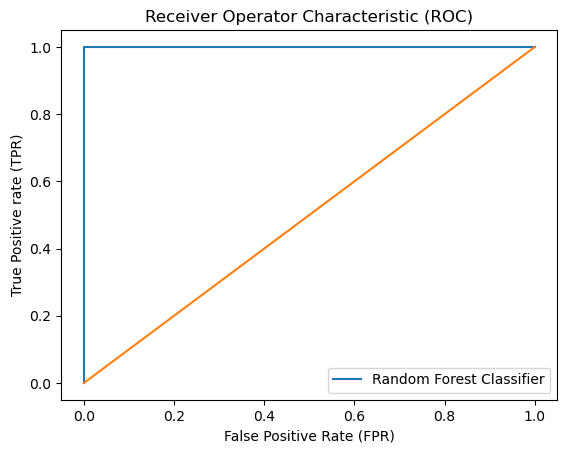

In [47]:
def main():
           
    print('Building model...')
    rf_model = build_model()
    print('model is built successfully')

    print('Training model...')
    rf_model.fit(X_train, y_train)
    print('model is trained successfully')

    print('Evaluating model...')
    evaluate_model(rf_model, X_train, y_train)
    
    print('Making predictions...')
    y_pred, pred_proba, fpr, tpr, thresh, dummy_fpr,\
    dummy_tpr, dummy_thresh = make_prediction(rf_model, X_test)
    
    print('Estimate a_u_c score...')
    auc_score(y_pred, pred_proba)

    print('Saving prediction as a csv file...')
    save_prediction(sample_submission, 'client_id', pred_proba)
    print('csv saved!')
    
    print('Plotting roc_auc curve...')
    roc_plot(pred_proba, fpr, tpr, thresh, dummy_fpr, dummy_tpr, dummy_thresh)
    print('Done!')

if __name__ == '__main__':
    main()

<a id='result'></a>
## Discussion of Results.

Above is a Receiver Operator Characteristic (ROC) plot. ROC is a metric that can be used to taste a binary classifier machine learning model. It plots the TPR vs FPR at various thresholds as can be seen here. 
The plot takes the shape of a right-angled triangle. This suggests that my model did almost a perfect job in predicting the test dataset.

The Area Under the Curve (AUC) is the measure of the ability of a binary classifier to distinguish between classes and is used as a summary of the ROC curve. The closer it is to 1, the better the model.
The auc score for my model is 1.0 which is perfect.

<a id='conclude'></a>
# Conclusion

The aim of this project was to detect and recognize clients involved in fraudulent activities. After data exploration and modeling, here are my findings: 
1. A little over 90% of deals were not fraud (0) and less than 10% were fraud.
2. The model has auc score of 1.0. This means the model has been able to correctly classify all the transactions. This is so because the the test data are extracts from the train data. So it is unknown whether the model can generalise well on entirely new and different data from the train data.